In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import os
import cv2
from PIL import Image as ImagePIL
import matplotlib as mpl

from sklearn.model_selection import train_test_split
import tensorflow as tf
#import optuna


from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, Input,Conv2DTranspose
from tensorflow.keras.callbacks import EarlyStopping


%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Kaggle trainning set
os.chdir("/content/drive/MyDrive/OCR_summer/OCR_Dataset")

train_dir = "/content/drive/MyDrive/OCR_summer/train"
Clean_train_dir = "/content/drive/MyDrive/OCR_summer/train_cleaned"
test_img_dir = "/content/drive/MyDrive/OCR_summer/OCR_Dataset/train_demo"
outcome_dir = "/content/drive/MyDrive/OCR_summer/OCR_Dataset/train_outcome"

train_img = sorted(os.listdir(train_dir))
Clean_train_img = sorted(os.listdir(Clean_train_dir))
test_img =sorted(os.listdir(test_img_dir))

In [ ]:
#Test image size
#img = cv2.imread("/content/drive/MyDrive/OCR_summer/OCR_Dataset/train_demo/IMG_0834.JPG")  
#size = img.shape
#size

In [ ]:

IMG_WIDTH = 420*(2)
IMG_HEIGHT = 540*(2)

# prepare function
def sizedown_image(path):
    img = cv2.imread(path)
    img = np.asarray(img, dtype="float32")
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = np.reshape(img, (IMG_HEIGHT, IMG_WIDTH, 1))
    
    return img

In [ ]:
train = []
train_cleaned = []
test = []

#i = 0

for f in train_img:
#    if i <= 75:
#       i = i+1
       train.append(sizedown_image( train_dir + '/'+ f))

#i = 0

for f in Clean_train_img:
#    if i <= 75:
#      i=i+1
      train_cleaned.append(sizedown_image(Clean_train_dir+'/' + f))

#i = 0

for f in test_img:
#    if i <= 75: 
#      i=i+1
      test.append(sizedown_image(test_img_dir + '/' + f))

X_train_temp = np.asarray(train)
Y_train_temp = np.asarray(train_cleaned)
test = np.asarray(test)

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train_temp, Y_train_temp, test_size=0.1)

In [ ]:
#My encoder 1

def model():
    input_layer = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1))
    
    # encoding
    x = Conv2D(32, (3, 3), activation='sigmoid', padding='same')(input_layer)
    x = MaxPooling2D((2,2),padding = "same")(x)
    x = Conv2D(16, (3, 3), activation='sigmoid', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    # decoding
    x = Conv2DTranspose(16, (3, 3), strides = 2,activation='sigmoid', padding='same')(x)
    x = Conv2DTranspose(32, (3, 3), strides = 2,activation='sigmoid', padding='same')(x)
    output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    model = Model(inputs=[input_layer], outputs=[output_layer])
    model.compile(optimizer='adam' , loss='mean_squared_error', metrics=['mae'])
    return model


model = model()
model.summary()

In [ ]:
callback = EarlyStopping(monitor='loss', patience=10)
history = model.fit(X_train, Y_train, validation_data = (X_val, Y_val), epochs=60, batch_size=5, verbose=1, callbacks=[callback])

Epoch 1/60
26/26 [==============================] - 288s 11s/step - loss: 0.0746 - mae: 0.2132 - val_loss: 0.0540 - val_mae: 0.1405
Epoch 2/60
26/26 [==============================] - 284s 11s/step - loss: 0.0573 - mae: 0.1436 - val_loss: 0.0535 - val_mae: 0.1445
Epoch 3/60
26/26 [==============================] - 285s 11s/step - loss: 0.0561 - mae: 0.1559 - val_loss: 0.0528 - val_mae: 0.1604
Epoch 4/60
26/26 [==============================] - 285s 11s/step - loss: 0.0557 - mae: 0.1665 - val_loss: 0.0528 - val_mae: 0.1639
Epoch 5/60
26/26 [==============================] - 285s 11s/step - loss: 0.0557 - mae: 0.1662 - val_loss: 0.0528 - val_mae: 0.1619
Epoch 6/60
26/26 [==============================] - 284s 11s/step - loss: 0.0557 - mae: 0.1652 - val_loss: 0.0528 - val_mae: 0.1618
Epoch 7/60
26/26 [==============================] - 284s 11s/step - loss: 0.0557 - mae: 0.1659 - val_loss: 0.0528 - val_mae: 0.1623
Epoch 8/60
26/26 [==============================] - 283s 11s/step - loss: 0.

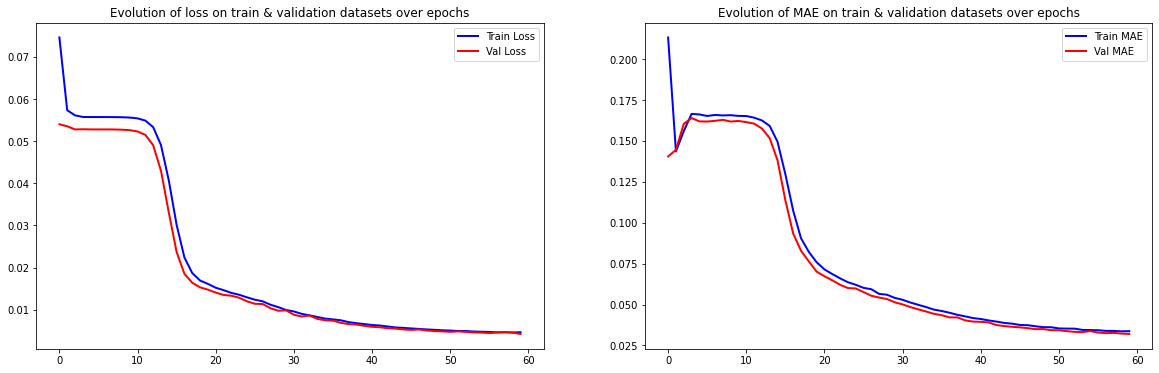

In [ ]:
#Check model outcome
epoch_loss = history.history['loss']
epoch_val_loss = history.history['val_loss']
epoch_mae = history.history['mae']
epoch_val_mae = history.history['val_mae']

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(range(0,len(epoch_mae)), epoch_mae, 'b-', linewidth=2, label='Train MAE')
plt.plot(range(0,len(epoch_val_mae)), epoch_val_mae, 'r-', linewidth=2,label='Val MAE')
plt.title('Evolution of MAE on train & validation datasets over epochs')
plt.legend(loc='best')

plt.show()

In [ ]:
#Save the model
os.chdir('/content/drive/MyDrive/OCR_summer/OCR_Dataset') 
model.save_weights('./Goodmodel1/epochs60')

In [ ]:
testoutcome = model.predict( X_train_temp ,verbose = 1, batch_size = 1)

144/144 [==============================] - 75s 513ms/step


In [ ]:
i = 0 
for image in testoutcome:
  im_path = outcome_dir +'/'+ test_img[i]
  mpl.image.imsave(im_path, image[:,:,0], cmap='gray')
  i += 1

IndexError: ignored

In [ ]:
#My encoder 2

def model():
    input_layer = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1))
    
    # encoding
    x = Conv2D(32, (3, 3), activation='sigmoid', padding='same')(input_layer)
    x = MaxPooling2D((2,2),padding = "same")(x)
    x = Conv2D(16, (3, 3), activation='sigmoid', padding='same')(x)
    x = MaxPooling2D((2,2),padding = "same")(x)
    x = Conv2D(8, (3, 3), activation='sigmoid', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    # decoding
    x = Conv2DTranspose(8, (3, 3), strides = 2,activation='sigmoid', padding='same')(x)
    x = Conv2DTranspose(16, (3, 3), strides = 2,activation='sigmoid', padding='same')(x)
    x = Conv2DTranspose(32, (3, 3), strides = 2,activation='sigmoid', padding='same')(x)
    output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    model = Model(inputs=[input_layer], outputs=[output_layer])
    model.compile(optimizer='adam' , loss='mean_squared_error', metrics=['mae'])
    return model


model = model()
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1080, 840, 1)]    0         
                                                                 
 conv2d_9 (Conv2D)           (None, 1080, 840, 32)     320       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 540, 420, 32)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 540, 420, 16)      4624      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 270, 210, 16)     0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 270, 210, 8)       1160

In [ ]:
callback = EarlyStopping(monitor='loss', patience=10)
history = model.fit(X_train, Y_train, validation_data = (X_val, Y_val), epochs=70, batch_size=5, verbose=1, callbacks=[callback])

Epoch 1/70
26/26 [==============================] - 322s 12s/step - loss: 0.0638 - mae: 0.1802 - val_loss: 0.0593 - val_mae: 0.1407
Epoch 2/70
26/26 [==============================] - 310s 12s/step - loss: 0.0577 - mae: 0.1513 - val_loss: 0.0573 - val_mae: 0.1675
Epoch 3/70
26/26 [==============================] - 316s 12s/step - loss: 0.0568 - mae: 0.1696 - val_loss: 0.0573 - val_mae: 0.1657
Epoch 4/70
26/26 [==============================] - 311s 12s/step - loss: 0.0568 - mae: 0.1658 - val_loss: 0.0573 - val_mae: 0.1665
Epoch 5/70
26/26 [==============================] - 317s 12s/step - loss: 0.0568 - mae: 0.1668 - val_loss: 0.0573 - val_mae: 0.1666
Epoch 6/70
26/26 [==============================] - 316s 12s/step - loss: 0.0568 - mae: 0.1668 - val_loss: 0.0573 - val_mae: 0.1657
Epoch 7/70
26/26 [==============================] - 318s 12s/step - loss: 0.0568 - mae: 0.1661 - val_loss: 0.0573 - val_mae: 0.1675
Epoch 8/70
26/26 [==============================] - 313s 12s/step - loss: 0.